In [1]:
# download the dataset
%%shell
pip install google-trans-new
cd /content
path='/content/input'
comp='stanfordSentimentTreebank'

mkdir -p $path
mkdir -p /content/working/

wget -c 'http://nlp.stanford.edu/~socherr/'$comp'.zip' -O $comp'.zip'

# wget -c 'https://github.com/allenai/spv2/raw/master/model/glove.6B.100d.txt.gz'

unzip -q $comp.zip -d $path
# gunzip -c 'glove.6B.100d.txt.gz' > '/content/working/glove.6B.100d.txt'
rm -rf '/content/input/__MACOSX'

--2021-06-13 10:18:49--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2021-06-13 10:18:49--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr 100%[===================>]   6.08M  6.69MB/s    in 0.9s    

2021-06-13 10:18:50 (6.69 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [6372817/6372817]



In [2]:
# Import Library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random
import time
import os

import torch, torchtext
from torchtext.legacy import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

import google_trans_new
from google_trans_new import google_translator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
DATA_PATH = '/content/input/stanfordSentimentTreebank'
WORK_PATH = '/content/working'

DATA_SET = 'datasetSentences.txt'
TRAIN_DEV_TEST = 'datasetSplit.txt'
PHRASE_DICT = 'dictionary.txt'
PHRASE_LABELS = 'sentiment_labels.txt'

# Manual Seed
def getRandomState():
    return np.random.RandomState(RANDOM_SEED)

RANDOM_SEED = 43
torch.manual_seed(RANDOM_SEED)

# Create translator object
translator = google_translator()
available_langs = list(google_trans_new.LANGUAGES.keys())

In [4]:
def clean_data(x):
    char_dict = {
        '-LRB-' : '(',
        '-RRB-' : ')',
        '\xa0' : ' ',
        '\xc2' : '',
        '\xc3\x83\xc2\xa0' : 'a',
        'à' : 'a',
        'Â' : '',
        'â' : 'a',
        'ã' : 'a',
        'Ã¡' : 'a',
        'Ã¢' : 'a',
        'Ã£' : 'a',
        'Ã¦' : 'ae',
        'Ã§' : 'c',
        'Ã¨' : 'e',
        'Ã©' : 'e',
        'Ã­' : 'i',
        'Ã¯' : 'i',
        'Ã±' : 'n',
        'Ã³' : 'o',
        'Ã´' : 'o',
        'Ã¶' : 'o',
        'Ã»' : 'u',
        'Ã¼' : 'u',
        'æ' : 'ae',
        'ç' : 'c',
        'è' : 'e',
        'é' : 'e',
        'í' : 'i',
        'ï' : 'i',
        'ñ' : 'n',
        'ó' : 'o',
        'ô' : 'o',
        'ö' : 'o',
        'û' : 'u',
        'ü' : 'u'
    }
    for keys in char_dict.keys():
        x = x.replace(keys, char_dict[keys])
    return x

def sentiment_for_phrases():
    # import phrase dictionary
    df_dictionary = pd.read_table(
        filepath_or_buffer = os.path.join(DATA_PATH, PHRASE_DICT)
        , header = None
    )
    df_dictionary = df_dictionary[0].str.split('|', expand=True)
    df_dictionary.columns = ['phrase', 'phrase_ids']

    # done to join it with the sentence dataset
    df_dictionary['sentence'] = df_dictionary['phrase'].apply(lambda x: clean_data(x))

    # import sentiments from 
    df_sentiment = pd.read_table(
        filepath_or_buffer = os.path.join(DATA_PATH, PHRASE_LABELS)
        , header = None
        , skiprows=1
    )
    df_sentiment = df_sentiment[0].str.split('|', expand=True)
    df_sentiment.columns = ['phrase_ids', 'sentiment_values']
    df_sentiment['sentiment_values'] = df_sentiment['sentiment_values'].astype('float32')
    df_sentiment['sentiment'] = df_sentiment['sentiment_values'].apply(lambda x: 4 if 0.8 < x <= 1.0 else 3 if 0.6 < x <= 0.8 else 2 if 0.4 < x <= 0.6 else 1 if 0.2 < x <= 0.4 else 0)
    
    # df_sentiment['sentiment_25'] = df_sentiment['sentiment_values'].apply(lambda x: int(x*24+1))

    # merge and returm the sentiment dictionary
    return df_dictionary.merge(
        df_sentiment
        , how='inner'
        , on = 'phrase_ids'
    )

def import_and_create_split_mapping():
    # import the sentence dataset
    df_data_sentence = pd.read_table(os.path.join(DATA_PATH, DATA_SET))

    df_data_sentence['sentence'] = df_data_sentence['sentence'].apply(lambda x: clean_data(x))

    return df_data_sentence

In [5]:
# import sentences from rotten tomatoes
df  = import_and_create_split_mapping()

# import processed sentiment dictionary
df_sentiment_dict = sentiment_for_phrases()

df = df.merge(
    df_sentiment_dict
    , how = 'inner'
    , on = 'sentence'
)

In [6]:
(df_train, df_valid) = train_test_split(df, test_size=0.3, random_state=random.seed(RANDOM_SEED))

assert len(df_train) + len(df_valid) == len(df)

In [7]:
sentence = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)
# label25 = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [8]:
fields = [('sentence', sentence),('sentiment', label)]

In [9]:
train = [data.Example.fromlist([df_train.sentence[i], df_train.sentiment[i]], fields) for i in df_train.index]
valid = [data.Example.fromlist([df_valid.sentence[i], df_valid.sentiment[i]], fields) for i in df_valid.index]

In [10]:
# Creating dataset
train = data.Dataset(train, fields)
valid = data.Dataset(valid, fields)

In [11]:
(len(train), len(valid))

(8300, 3558)

In [12]:
vars(train.examples[10])

{'sentence': ['No',
  'amount',
  'of',
  'nostalgia',
  'for',
  'Carvey',
  "'s",
  'glory',
  'days',
  'can',
  'disguise',
  'the',
  'fact',
  'that',
  'the',
  'new',
  'film',
  'is',
  'a',
  'lame',
  'kiddie',
  'flick',
  'and',
  'that',
  'Carvey',
  "'s",
  'considerable',
  'talents',
  'are',
  'wasted',
  'in',
  'it',
  '.'],
 'sentiment': 0}

In [13]:
sentence.build_vocab(train)
label.build_vocab(train)

In [14]:
print('Size of input vocab : ', len(sentence.vocab))
print('Size of label vocab : ', len(label.vocab))
print('Top 10 words appreared repeatedly :', list(sentence.vocab.freqs.most_common(10)))
print('Labels : ', label.vocab.stoi)

Size of input vocab :  16975
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 7829), (',', 6978), ('the', 5905), ('and', 4352), ('of', 4319), ('a', 4245), ('to', 2976), ('-', 2650), ("'s", 2477), ('is', 2428)]
Labels :  defaultdict(None, {1: 0, 3: 1, 2: 2, 4: 3, 0: 4})


In [15]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)

In [16]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(sentence.vocab.stoi, tokens)

In [17]:
class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                        #  bidirectional=True,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # self.fc25 = nn.Linear(hidden_dim, output_dim[1])
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]

        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions, hid dim]
        #cell = [batch size, num layers * num directions, hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)

        # dense_outputs25 = self.fc25(hidden)
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)

        # output25 = F.softmax(dense_outputs25[0], dim=1)
            
        return output

In [30]:
# Define hyperparameters
size_of_vocab = len(sentence.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 5
num_layers = 4
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [31]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(16975, 300)
  (encoder): LSTM(300, 100, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)
The model has 5,496,205 trainable parameters


In [32]:
# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
# criterion25 = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)
# criterion25 = criterion25.to(device)

In [33]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0

    # epoch_loss25 = 0
    # epoch_acc25 = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence   
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()
        
        # compute the loss
        loss = criterion(predictions, batch.sentiment)
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.sentiment)
        
        # backpropage the loss and compute the gradients
        loss.backward(retain_graph=True)      
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item() 
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [34]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.sentiment)
            acc = binary_accuracy(predictions, batch.sentiment)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [35]:
N_EPOCHS = 40
best_valid_loss = float('inf')
val_losses = []
train_losses = []

val_accuracy = []
train_accuracy = []

for epoch in range(N_EPOCHS):
     
    start_time = time.time()
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    val_losses.append(valid_loss)
    val_accuracy.append(valid_acc)


    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch {epoch+1} | Time Taken: {(time.time() - start_time):.2f}s')
    print(f'\tTrain Loss  5 labels: {train_loss:.3f} | Train Acc  5 labels: {train_acc*100:.2f}%')
    print(f'\t Val. Loss  5 labels: {valid_loss:.3f} |  Val. Acc  5 labels: {valid_acc*100:.2f}% \n')

Epoch 1 | Time Taken: 2.52s
	Train Loss  5 labels: 1.591 | Train Acc  5 labels: 24.96%
	 Val. Loss  5 labels: 1.574 |  Val. Acc  5 labels: 27.73% 

Epoch 2 | Time Taken: 2.41s
	Train Loss  5 labels: 1.577 | Train Acc  5 labels: 28.79%
	 Val. Loss  5 labels: 1.571 |  Val. Acc  5 labels: 27.98% 

Epoch 3 | Time Taken: 2.40s
	Train Loss  5 labels: 1.572 | Train Acc  5 labels: 30.86%
	 Val. Loss  5 labels: 1.565 |  Val. Acc  5 labels: 30.83% 

Epoch 4 | Time Taken: 2.41s
	Train Loss  5 labels: 1.559 | Train Acc  5 labels: 33.83%
	 Val. Loss  5 labels: 1.557 |  Val. Acc  5 labels: 31.98% 

Epoch 5 | Time Taken: 2.37s
	Train Loss  5 labels: 1.533 | Train Acc  5 labels: 37.38%
	 Val. Loss  5 labels: 1.547 |  Val. Acc  5 labels: 33.65% 

Epoch 6 | Time Taken: 2.40s
	Train Loss  5 labels: 1.500 | Train Acc  5 labels: 40.62%
	 Val. Loss  5 labels: 1.541 |  Val. Acc  5 labels: 34.40% 

Epoch 7 | Time Taken: 2.41s
	Train Loss  5 labels: 1.473 | Train Acc  5 labels: 42.98%
	 Val. Loss  5 labels: 1.

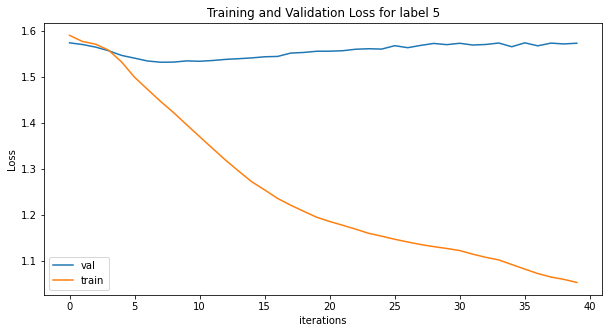

In [36]:
# Plotting the train and validation loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss for label 5")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

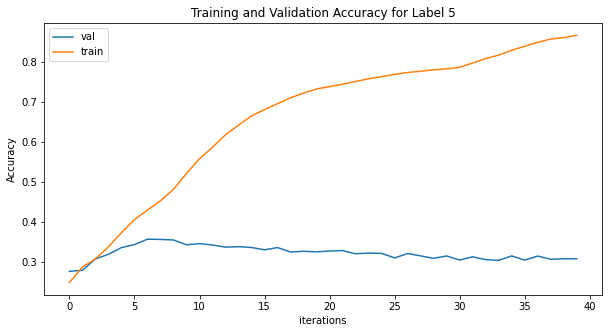

In [37]:
# Plotting the train and validation Accuracy

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy for Label 5")
plt.plot(val_accuracy, label="val")
plt.plot(train_accuracy, label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [38]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

categories = {0: "very negative", 1:"negative", 2:"neutral", 3:'positive', 4:'very positive'}
inv_categories = {v: k for k, v in categories.items()}

def classify_tweet(sentence):
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [39]:
df_eval = pd.DataFrame([(df_valid['sentence'][idx], df_valid['sentiment'][idx], inv_categories[classify_tweet(df_valid['sentence'][idx])]) for idx in df_valid.index], columns=['sentence','sentiment', 'sentiment_pred'])

In [40]:
df_eval.head(10)

,sentence,sentiment,sentiment_pred
0,"Art-house to the core , Read My Lips is a genr...",3,1
1,The film 's images give a backbone to the comp...,3,1
2,When you think you 've figured out Bielinsky '...,2,1
3,The story drifts so inexorably into cliches ab...,1,1
4,The film takes the materials of human tragedy ...,2,1
5,"The movie , while beautiful , feels labored , ...",2,1
6,Claude Chabrol 's camera has a way of gently s...,3,1
7,It 's something of the ultimate Scorsese film ...,4,1
8,There is n't one moment in the film that surpr...,0,0
9,Immediately .,2,0


In [41]:
num_correct, num_incorrect = len(df_eval[df_eval['sentiment'] == df_eval['sentiment_pred']]), len(df_eval[df_eval['sentiment'] != df_eval['sentiment_pred']])

print(f'correct count: {num_correct}\nincorrect count: {num_incorrect}')
print(f'correct count: {num_correct/len(df_eval)*100:.2f}%\nincorrect count: {num_incorrect/len(df_eval)*100:.2f}%')

correct count: 642
incorrect count: 2916
correct count: 18.04%
incorrect count: 81.96%


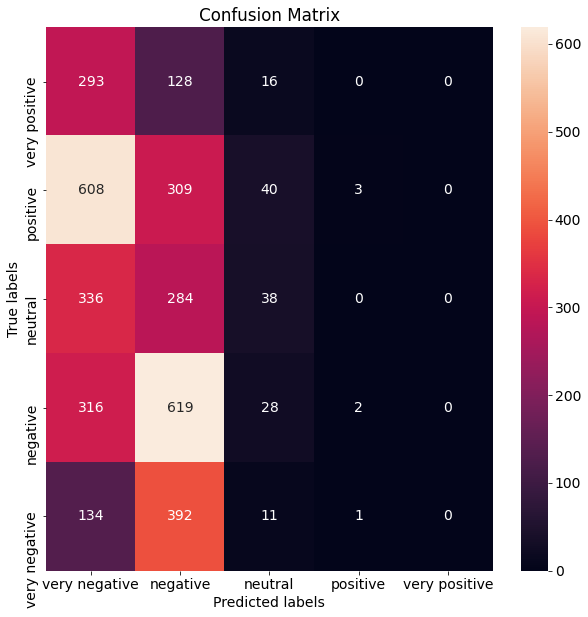

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_eval['sentiment'].values, df_eval['sentiment_pred'].values)

import seaborn as sns
import matplotlib.pyplot as plt     


font = {'font.size': 14}
plt.rcParams.update(font)
plt.figure(figsize=(10, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(categories.values())); ax.yaxis.set_ticklabels(list(categories.values())[::-1]);